In [1]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from MMD import mmd_rbf, mmd_linear
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [2]:
model_params = {
        'hidden_size': 32,
        'embedding_size': 16,
        'n_layers': 1,
        'kernel_size': 2,
        'decoder_order': 1,
        'layer_norm': True,
        'dropout': 0.05,
        'merge_mode': 'mean'
}
optim_params = {'lr': 0.00001, 'weight_decay': 0.01}

optim = 'RMSprop' # SGD or Adam

In [3]:
p_fault, p_noise = 0.0015, 0.05
dataset = add_missing_values(PemsBay(),
                                p_fault=p_fault,
                                p_noise=p_noise,
                                min_seq=12,
                                max_seq=12 * 4,
                                seed=56789)
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe(),
                                    mask=dataset.training_mask,
                                    eval_mask=dataset.eval_mask,
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='fit')
dm.trainset = list(range(len(torch_dataset)))

/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/pems_bay.py:81: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  date_range = pd.date_range(df.index[0], df.index[-1], freq='5T')
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/tsl/datasets/pems_bay.py:93: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


In [4]:
model_cls = GRINModel

model_kwargs = dict(n_nodes=torch_dataset.n_nodes,
                    input_size=torch_dataset.n_channels)


model_cls.filter_model_args_(model_kwargs)
model_kwargs.update(model_params)

loss_fn = torch_metrics.MaskedMAE()

log_metrics = {
    'mae': torch_metrics.MaskedMAE(),
    'mse': torch_metrics.MaskedMSE(),
    'mape': torch_metrics.MaskedMAPE(),
}

scheduler_class = getattr(torch.optim.lr_scheduler, 'CosineAnnealingLR')
scheduler_kwargs = {'eta_min': 0.0001, 'T_max': 300}

# setup generator
imputer = Imputer(model_class=model_cls,
                model_kwargs=model_kwargs,
                optim_class=getattr(torch.optim, optim),
                optim_kwargs=dict(optim_params),
                loss_fn=loss_fn,
                metrics=log_metrics,
                scheduler_class=scheduler_class,  
                scheduler_kwargs=scheduler_kwargs,
                scale_target=True,
                impute_only_missing=False)

imputer.load_model('pred_model.ckpt')


In [5]:

exp_logger = TensorBoardLogger(save_dir=f'logs/prediction/grin/',
                                    name='tensorboard')
early_stop_callback = EarlyStopping(monitor='val_loss',
                                        patience=50,
                                        mode='min')

checkpoint_callback = ModelCheckpoint(
    dirpath='logs/prediction/grin/',
    filename='best-model-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    monitor='val_loss',
    mode='min',
)

trainer = Trainer(
    max_epochs=500,
    default_root_dir='logs/prediction/grin/',
    logger=exp_logger,
    accelerator='cpu',
    devices=1,
    gradient_clip_val=5,
    callbacks=[early_stop_callback, checkpoint_callback])

trainer.ckpt_path= 'pred_model.ckpt'

imputer.freeze()
trainer.test(imputer, datamodule=dm)

GPU available: True (cuda), used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Missing logger folder: logs/prediction/grin/tensorboard
Restoring states from the checkpoint path at pred_model.ckpt
Loaded model weights from the checkpoint at pred_model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

Only args ['mask', 'edge_index', 'x', 'edge_weight'] are forwarded to the model (GRINModel). 
/data/p.magos/.pyenv/versions/3.11.9/lib/python3.11/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [6]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
res = dict(test_mae=loss_fn(torch.tensor(y_hat), y_true))
res

Restoring states from the checkpoint path at pred_model.ckpt
Loaded model weights from the checkpoint at pred_model.ckpt
/Users/paulmagos/.pyenv/versions/3.11.9/envs/Thesis/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0: 100%|██████████| 5212/5212 [00:49<00:00, 105.68it/s]


TypeError: 'int' object is not callable

In [31]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)
pred = scalers['target'].inverse_transform(y_hat)

/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_88935/700346191.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_true = torch.tensor(y_true)
/var/folders/2f/0xjdq0xn6b3cfw3v2k2svn3m0000gn/T/ipykernel_88935/700346191.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat = torch.tensor(y_hat)


In [36]:
X = y_true.reshape(y_true.shape[0], -1)
Y = pred.reshape(y_true.shape[0], -1)
mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.00038377929013222456

In [37]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

tensor(5367.0469)

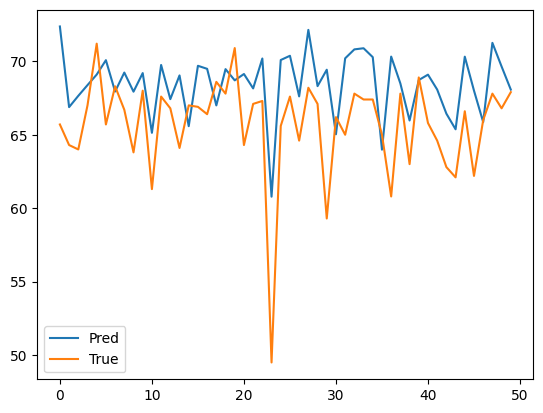

In [38]:
plt.plot(pred[100][0][:50], label='Pred')
plt.plot(y_true[100][0][:50], label='True')
plt.legend()